# Clustering Algorithms -  Centroid-based or Partition Clustering

**Partitional clustering** divides data objects into nonoverlapping groups. In other words, no object can be a member of more than one cluster, and every cluster must have at least one object.

These techniques require the user to specify the number of clusters, indicated by the variable k. Many partitional clustering algorithms work through an iterative process to assign subsets of data points into k clusters.

Most partitional clustering algorithms are **nondeterministic**, meaning they could produce different results from two separate runs even if the runs were based on the same input.

Partitional clustering methods have several **strengths**:

- They work well when clusters have a spherical shape.
- They’re scalable with respect to algorithm complexity.

They also have several **weaknesses**:

- They’re not well suited for clusters with complex shapes and different sizes.
- They break down when used with clusters of different densities.

Pre-defining the number of clusters at the initial stage is the most crucial yet most complicated stage for the clustering approach. Despite its drawbacks, partitional clustering algorithms are vastly used for surfacing and optimizing large datasets. 

## Farthest-first traversal

#### Rationale

The Farthest-First Traversal (FFT) algorithm is a clustering algorithm that is used to group data points into clusters based on their distance from one another. The basic idea behind FFT is to select a starting point and then repeatedly choose the farthest point from the current cluster until a specified number of clusters have been created.

The distance between two points is typically measured using the Euclidean distance metric, which calculates the distance between two points in n-dimensional space as the square root of the sum of the squares of the differences between their corresponding coordinates.

**Euclidian Distance**: we define the Euclidean distance between points v = (v1, ... , vm) and w = (w1, ... , wm) in m-dimensional space, denoted d(v, w):

$$
  d(v, w) = \sqrt{\sum_{i=1}^m  (v_i - w_i)^2}
$$


#### Implementation

Here's how the algorithm works:

1. Select a random data point as the starting point for the first cluster.
2. Find the point that is farthest from the first cluster and assign it to the second cluster.
3. Repeat step 2, but now find the point that is farthest from the first two clusters and assign it to the third cluster.
4. Continue this process until the desired number of clusters have been created.

Let's write it in Python:

In [9]:
import numpy as np
import pandas as pd

def farthest_first_traversal(X, k):
    """
    Implementation of Farthest-First Traversal clustering algorithm
    
    Parameters:
    X: pandas DataFrame, shape (n_samples, n_features)
        The input data to be clustered
    k: int
        The number of clusters to create
        
    Returns:
    centroids: array-like, shape (k, n_features)
        The k centroids chosen by the algorithm
    labels: array-like, shape (n_samples,)
        The cluster assignments for each data point
    """
    # Convert the input DataFrame to a NumPy array
    X = X.values
    
    # Choose a random point as the starting point
    start_point = np.random.choice(X.shape[0], size=1)
    
    # Initialize the set of centroids with the starting point
    centroids = X[start_point]
    
    # Initialize the set of cluster assignments
    labels = np.zeros(X.shape[0])
    
    # Repeat until k centroids have been chosen
    for i in range(1, k):
        # Calculate the distance between each point and the centroids
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        
        # Choose the point that is farthest from the existing centroids
        farthest_point = np.argmax(np.min(distances, axis=0))
        
        # Add the farthest point to the centroids
        centroids = np.vstack((centroids, X[farthest_point]))
        
    # Assign each point to the closest centroid
    for i in range(X.shape[0]):
        distances = np.sqrt(((X[i] - centroids)**2).sum(axis=1))
        labels[i] = np.argmin(distances)
    
    return centroids, labels

Now we can test the algorithm on a sample dataset. 

In [10]:
# load data from txt file
data = pd.read_csv("data/rosalind_ba8a.txt", delimiter=" ", header=None)

print(data.head())

      0    1     2     3
0   9.1  0.5   7.7  11.6
1   4.4  7.1  15.4   3.3
2   1.3  3.9  12.4  17.1
3  14.5  5.7   0.7   6.4
4   0.1  5.6  14.2   3.1


In [11]:
centroids, labels = farthest_first_traversal(data, 3)

# Print the centroids DataFrame
centroids_df = pd.DataFrame(data=centroids, columns=data.columns)
print(centroids_df)

      0     1     2     3
0  10.7   3.5   3.0   0.2
1   0.5   7.0  32.8  30.9
2   7.3  42.6   5.5   3.6


Just above is our centroids dataframe. We can now visualize the clusters to which data points have been assigned. Our input data has 4 features, it may be difficult to visualize the cluster assignments using a scatter plot. In this case, we can use a parallel coordinates plot, which plots each data point as a line spanning across all the features.

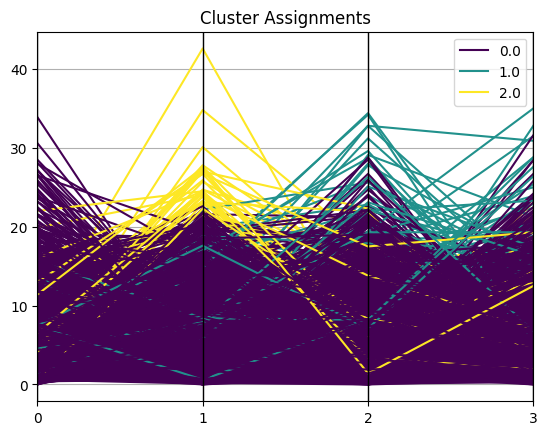

In [12]:
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt

# Add the cluster assignments to the input data as a new column
data['Cluster'] = labels

# Create a parallel coordinates plot
parallel_coordinates(data, 'Cluster', colormap='viridis')
plt.title('Cluster Assignments')
plt.show()




#### Closing comments

The FFT algorithm is simple to implement and can be quite effective for data sets with well-separated clusters. However, the algorithm has some strong limitations that should be taken into account when considering its use:

1. Sensitivity to initialization: The FFT algorithm is sensitive to the initial choice of the starting point, which can significantly affect the quality of the resulting clustering. If the starting point is far from the true center of the cluster, the algorithm may converge to a suboptimal solution.
2. Lack of flexibility: The FarthestFirstTraversal algorithm is limited to partitioning the data into a fixed number of clusters, specified in advance. This can be a disadvantage when the number of clusters is not known a priori or when the data does not naturally fall into a fixed number of clusters.
3. **Inability to handle noise and outliers**: The FarthestFirstTraversal algorithm does not have a mechanism for handling noise and outliers, which can affect the quality of the resulting clustering. Outliers can be mistakenly assigned to the nearest cluster center, leading to incorrect clustering results.
4. Computationally expensive: The FarthestFirstTraversal algorithm can be computationally expensive, especially for large datasets, since it requires computing pairwise distances between all data points and all cluster centers at each iteration.


## Squared Error Distortion

To address the limitations of methods that select centroids so that they minimize the maximum distance between points in the data and their nearest centroid, let us introduce a new scoring function. **Squared error distortion** can be used to evaluate the performance of a clustering algorithm by calculating the sum of the squared distances between each data point and its assigned cluster centroid. 

Formally, let C be the set of clusters, and let ci be the centroid of cluster i. The squared error distortion can be calculated as follows:

SE = ∑(x - ci)^2

where x is a data point and ci is the centroid of its assigned cluster.

Let's compute the squared error distortion resulting from clustering done with our FTT algorithm. 

In [13]:
def compute_distortion(X, centroids, labels):
    """
    Compute the squared error distortion resulting from clustering
    
    Parameters:
    X: pandas DataFrame, shape (n_samples, n_features)
        The input data that was clustered
    centroids: array-like, shape (k, n_features)
        The centroids returned by the clustering algorithm
    labels: array-like, shape (n_samples,)
        The cluster assignments for each data point
        
    Returns:
    distortion: float
        The squared error distortion resulting from clustering
    """
    # Convert the input DataFrame to a NumPy array
    X = X.values
    
    # Initialize the distortion
    distortion = 0
    
    # Compute the sum of squared distances between each point and its centroid
    for i in range(centroids.shape[0]):
        # Get the indices of the points in the current cluster
        mask = (labels == i)
    
        # Get the points in the current cluster
        cluster_points = X[mask]
    
        # If the current cluster is not empty, compute its distortion
        if len(cluster_points) > 0:
            # Add extra column and reshape centroid to have shape (1, 5)
            centroid = np.hstack((centroids[i], 0)).reshape(1, -1)

            # Compute the distances between each point in the current cluster and its centroid
            distances = np.sqrt(((cluster_points - centroid)**2).sum(axis=1))
            
            # Add the sum of squared distances to the overall distortion
            distortion += (distances**2).sum()
            
        # Divide by the number of data points to get the average distortion
        distortion /= X.shape[0]
    
    return distortion


In [14]:
# Compute the distortion
distortion = compute_distortion(data, centroids, labels)

# Print the distortion
print("Squared Error Distortion:", round(distortion,2))

Squared Error Distortion: 11.94


## Lloyd Algorithm for k-Means Clustering

### Rationale

The Lloyd Algorithm, also known as the k-Means Algorithm, is an iterative clustering algorithm used to partition a set of data points into k clusters. The algorithm aims to minimize the sum of squared distances between each data point and its nearest cluster center.

### Implementation

Here are the steps for the Lloyd Algorithm:

1. Initialize k cluster centers randomly from the data points or using a specific initialization method.
2. Assign each data point to the nearest cluster center based on the Euclidean distance.
3. Recalculate the cluster centers by taking the mean of all data points assigned to each cluster.
4. Repeat steps 2 and 3 until convergence is reached. Convergence is typically determined by a predetermined number of iterations or when the change in cluster centers becomes small.
5. The final result is k clusters, where each data point belongs to the cluster with the nearest cluster center.

Let's write it in Python:


Let's run it on the same dataset as before.

In [22]:
# load data from txt file
data = pd.read_csv("data/rosalind_ba8a.txt", delimiter=" ", header=None)

# set number of clusters
k = 3

# run k-means clustering algorithm
labels, centroids = kmeans(data, k)

(3, 4)


ValueError: Unable to coerce to Series/DataFrame, dimension must be <= 2: (3, 1, 4)

In [20]:
data.head()

,0,1,2,3
0,9.1,0.5,7.7,11.6
1,4.4,7.1,15.4,3.3
2,1.3,3.9,12.4,17.1
3,14.5,5.7,0.7,6.4
4,0.1,5.6,14.2,3.1


## Closing comments:

The Lloyd Algorithm, also known as the k-means clustering algorithm, has several limitations, including:

- Sensitive to initialization: The algorithm is sensitive to the initial placement of cluster centers, and different initializations may result in different local optima.
- Sensitive to outliers: The algorithm is sensitive to outliers, which may affect the placement of cluster centers and the resulting clusters.
- Requires a fixed number of clusters: The algorithm requires the number of clusters to be specified in advance, which may not always be known or appropriate for the data.
- Not suitable for high-dimensional data: As the number of dimensions increases, the distance metric used in the algorithm becomes less informative, and the algorithm may suffer from the "curse of dimensionality.
- May not work well for non-spherical clusters: The algorithm assumes that clusters are spherical and have similar sizes, which may not hold for all datasets. In some cases, the algorithm may fail to identify the underlying cluster structure, resulting in suboptimal solutions.
- Computationally expensive: The algorithm may be computationally expensive for large datasets or a large number of clusters, as it requires calculating distances and updating cluster centers for each iteration.


#### Comparison with FTT algorithm

The Lloyd Algorithm and the Furthest-First Traversal (FFT) Algorithm are two popular methods used for initializing cluster centers in k-means clustering. The FFT Algorithm selects k initial cluster centers that are as far apart from each other as possible.

Both algorithms have their own advantages and disadvantages, and the choice of initialization method depends on the specific problem and data. Here are some factors to consider when choosing between the two methods:

1. Speed: The FFT Algorithm is generally faster than the Lloyd Algorithm, as it only requires one pass over the data to select initial cluster centers. In contrast, the Lloyd Algorithm requires multiple iterations to converge to a solution.

2. Quality of clusters: The Lloyd Algorithm tends to produce higher quality clusters than the FFT Algorithm, as it iteratively refines the cluster centers and assignments to minimize the sum of squared distances. In contrast, the FFT Algorithm may produce suboptimal clusters if the selected initial cluster centers are not representative of the underlying data.

3. Sensitivity to outliers: The Lloyd Algorithm is more sensitive to outliers than the FFT Algorithm, as outliers may significantly affect the calculation of cluster centers and the resulting clusters. The FFT Algorithm is less sensitive to outliers, as it selects initial cluster centers that are far away from each other and therefore less likely to include outliers.

**Resources**:

- [K-Means Clustering in Python: A Practical Guide, by Kevin Arvai](https://realpython.com/k-means-clustering-python/#reader-comments)